<a href="https://colab.research.google.com/github/Kamruzzaman2200/Ai/blob/main/K_fold_D2_datset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔹 1. Install Required Libraries

In [27]:
!pip install imblearn boruta

# 🔹 2. Imports

In [28]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder

# Sampling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Feature selection
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay


# 🔹 3. Load Dataset

In [32]:
# Path to your dataset in Google Drive
file_path = "/content/drive/MyDrive/DataSets/dataset-2_9.csv"
df = pd.read_csv(file_path)

print("✅ Dataset loaded")
print("Shape:", df.shape)
df.head()


✅ Dataset loaded
Shape: (672, 55)


,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,PSQI10,PSQI11,PSQI12,PSQI13,PSQI14,PSQI15,PSQI16,PSQI17,PSQI18,PSQI19
0,15-30,Male,Overweight,Married,Higher secondary,Unemployed,High,Urban,Without family,Non-smoker,...,0,3,1,0,0,0,0,0,2,2
1,Above 30,Male,Normal,Married,Illiterate,Unemployed,Low,Rural,With family,Smoker,...,0,1,1,2,3,3,0,0,0,1
2,Above 30,Female,Normal,Unmarried,Primary,Unemployed,Middle,Rural,With family,Non-smoker,...,2,0,3,1,0,1,0,0,0,2
3,Above 30,Female,Normal,Married,Graduate/above,Student,Middle,Rural,With family,Non-smoker,...,1,1,0,1,1,2,0,0,0,1
4,Above 30,Male,Normal,Married,Graduate/above,Student,Middle,Rural,With family,Non-smoker,...,1,0,2,1,1,2,0,1,0,2


# 🔹 4. Data Cleaning & Encoding

In [33]:
# Clean column names
df.columns = df.columns.str.strip().str.lower()

target = "depression"

# Encode target (0/1)
df[target] = LabelEncoder().fit_transform(df[target].astype(str))

# Encode categorical features
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

print("✅ Encoded dataset")
df.info()


✅ Encoded dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 55 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   d1          672 non-null    int64
 1   d2          672 non-null    int64
 2   d3          672 non-null    int64
 3   d4          672 non-null    int64
 4   d5          672 non-null    int64
 5   d6          672 non-null    int64
 6   d7          672 non-null    int64
 7   d8          672 non-null    int64
 8   d9          672 non-null    int64
 9   d10         672 non-null    int64
 10  ucla1       672 non-null    int64
 11  ucla2       672 non-null    int64
 12  ucla3       672 non-null    int64
 13  ucla4       672 non-null    int64
 14  ucla5       672 non-null    int64
 15  ucla6       672 non-null    int64
 16  ucla7       672 non-null    int64
 17  ucla8       672 non-null    int64
 18  phq1        672 non-null    int64
 19  phq2        672 non-null    int64
 20  phq3        67

# 🔹 5. Check for Data Leakage

depression    1.000000
sum_phq       0.819409
phq7          0.485666
phq6          0.479650
phq8          0.471342
phq9          0.458283
phq5          0.416727
gad1          0.354467
gad2          0.351006
gad3          0.342959
phq2          0.335488
phq4          0.331257
phq3          0.323825
gad7          0.321814
psqi19        0.279136
Name: depression, dtype: float64


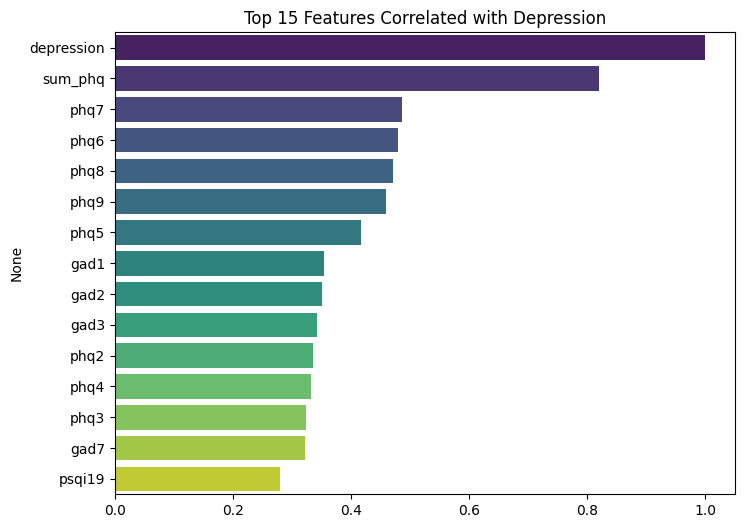

In [34]:
correlations = df.corr(numeric_only=True)[target].sort_values(ascending=False)
print(correlations.head(15))

plt.figure(figsize=(8, 6))
sns.barplot(x=correlations.head(15).values, y=correlations.head(15).index, palette="viridis")
plt.title("Top 15 Features Correlated with Depression")
plt.show()


# 🔹 6. Drop Leakage Features

In [35]:
# Example: remove PHQ total score if present
leakage_features = ["sum_phq"]

df = df.drop(columns=leakage_features, errors="ignore")

print("✅ Dropped leakage features:", leakage_features)
print("Remaining shape:", df.shape)


✅ Dropped leakage features: ['sum_phq']
Remaining shape: (672, 54)


# 🔹 7. Define X and y

In [36]:
X = df.drop(columns=[target])
y = df[target].astype(int)

print("Features:", X.shape, "| Target:", y.shape)


Features: (672, 53) | Target: (672,)


# 🔹 8. Boruta Feature Selection

In [37]:
rf_estimator = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)

boruta_selector = BorutaPy(
    estimator=rf_estimator,
    n_estimators='auto',
    verbose=2,
    random_state=42
)

# Fit Boruta
boruta_selector.fit(X.values, y.values)

# Get results
selected_features = X.columns[boruta_selector.support_].tolist()
tentative_features = X.columns[boruta_selector.support_weak_].tolist()

print("✅ Confirmed Features:", selected_features)
print("⚖️ Tentative Features:", tentative_features)

# Reduce dataset to only Boruta-confirmed features
X_boruta = X[selected_features]
print("New shape after Boruta:", X_boruta.shape)


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	53
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	53
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	53
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	53
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	53
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	53
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	53
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	19
Tentative: 	12
Rejected: 	22
Iteration: 	9 / 100
Confirmed: 	19
Tentative: 	12
Rejected: 	22
Iteration: 	10 / 100
Confirmed: 	19
Tentative: 	12
Rejected: 	22
Iteration: 	11 / 100
Confirmed: 	19
Tentative: 	12
Rejected: 	22
Iteration: 	12 / 100
Confirmed: 	20
Tentative: 	7
Rejected: 	26
Iteration: 	13 / 100
Confirmed: 	20
Tentative: 	7
Rejected: 	26
Iteration: 	14 / 100
Confirmed: 	20
Tentative: 	7
Rejected: 	26
Iteration: 	15 / 100
Confirmed: 	20
Tentative: 	7
Rejected: 	26
Iteration: 	16 / 100
Confirmed: 	21
Tentative: 	6
Re

# 🔹 9. Train-Test Split (Boruta features only)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X_boruta, y, test_size=0.2, stratify=y, random_state=42
)

print("X_train:", X_train.shape, "| X_test:", X_test.shape)


X_train: (537, 21) | X_test: (135, 21)


# 🔹 10. Cross-Validation with Multiple Models

In [39]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
scoring = {"accuracy": make_scorer(accuracy_score)}

scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler(),
}

classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
    "KNN": KNeighborsClassifier(),
    "SVM (RBF)": SVC(kernel="rbf", random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
}

results = []

for scaler_name, scaler in scalers.items():
    for clf_name, clf in classifiers.items():
        pipe = Pipeline([
            ('scaler', scaler),
            ('smote', SMOTE(random_state=42)),
            ('clf', clf)
        ])

        cv_out = cross_validate(pipe, X_boruta, y, cv=cv, scoring=scoring, return_train_score=False, n_jobs=-1)
        fold_scores = cv_out['test_accuracy']

        results.append({
            'Scaler': scaler_name,
            'Classifier': clf_name,
            'Mean_Accuracy': np.mean(fold_scores),
            'Std_Accuracy': np.std(fold_scores, ddof=1)
        })

results_df = pd.DataFrame(results).sort_values("Mean_Accuracy", ascending=False).reset_index(drop=True)
results_df


,Scaler,Classifier,Mean_Accuracy,Std_Accuracy
0,StandardScaler,Logistic Regression,0.995526,0.008366
1,RobustScaler,Logistic Regression,0.986604,0.010601
2,MinMaxScaler,Logistic Regression,0.972228,0.012082
3,MinMaxScaler,SVM (RBF),0.934052,0.017419
4,StandardScaler,SVM (RBF),0.934052,0.015769
5,RobustScaler,SVM (RBF),0.929092,0.019138
6,MinMaxScaler,Random Forest,0.913706,0.022184
7,RobustScaler,Random Forest,0.908730,0.023053
8,StandardScaler,Random Forest,0.906762,0.018094
9,StandardScaler,KNN,0.862602,0.027053


# 🔹 11. Best Model Evaluation (Test Set)

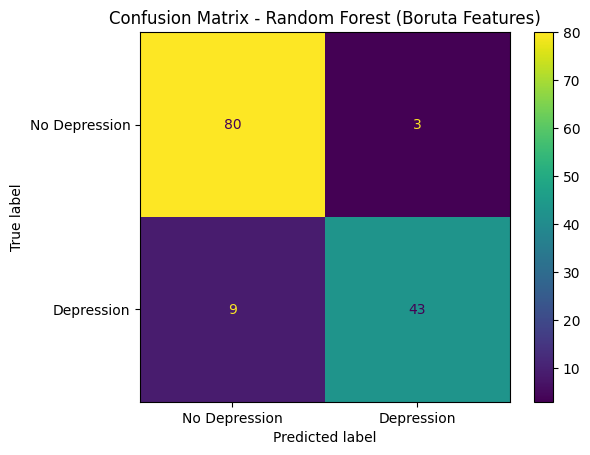

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93        83
           1       0.93      0.83      0.88        52

    accuracy                           0.91       135
   macro avg       0.92      0.90      0.90       135
weighted avg       0.91      0.91      0.91       135



In [40]:
best_model = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1))
])

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Depression', 'Depression'])
disp.plot(cmap="viridis")
plt.title("Confusion Matrix - Random Forest (Boruta Features)")
plt.show()

# Report
print("📋 Classification Report:")
print(classification_report(y_test, y_pred))


# 🔹 12. Feature Importance (Final Model)

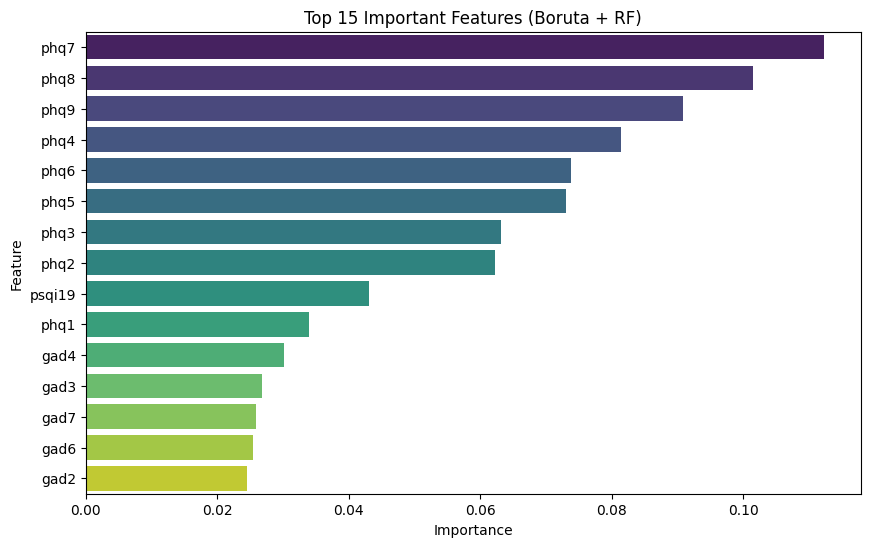

,Feature,Importance
7,phq7,0.112229
8,phq8,0.101493
9,phq9,0.090821
4,phq4,0.081447
6,phq6,0.073842
5,phq5,0.073016
3,phq3,0.063123
2,phq2,0.062160
20,psqi19,0.043116
1,phq1,0.033926


In [41]:
importances = best_model.named_steps['clf'].feature_importances_
feature_names = X_boruta.columns

feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp = feat_imp.sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feat_imp.head(15), palette="viridis")
plt.title("Top 15 Important Features (Boruta + RF)")
plt.show()

feat_imp


# 🔹 13. Save Final Model

In [42]:
import joblib

model_path = "/content/drive/MyDrive/Models/depression_boruta_rf.pkl"
joblib.dump(best_model, model_path)

print(f"✅ Final model saved at: {model_path}")


✅ Final model saved at: /content/drive/MyDrive/Models/depression_boruta_rf.pkl


In [43]:
display(results_df)

,Scaler,Classifier,Mean_Accuracy,Std_Accuracy
0,StandardScaler,Logistic Regression,0.995526,0.008366
1,RobustScaler,Logistic Regression,0.986604,0.010601
2,MinMaxScaler,Logistic Regression,0.972228,0.012082
3,MinMaxScaler,SVM (RBF),0.934052,0.017419
4,StandardScaler,SVM (RBF),0.934052,0.015769
5,RobustScaler,SVM (RBF),0.929092,0.019138
6,MinMaxScaler,Random Forest,0.913706,0.022184
7,RobustScaler,Random Forest,0.908730,0.023053
8,StandardScaler,Random Forest,0.906762,0.018094
9,StandardScaler,KNN,0.862602,0.027053
